## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [2]:
pwd

'/home/xzhang/Projects/cellpose'

In [1]:
import os
import json
import shutil
import tempfile
import time
import glob
import tifffile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nibabel as nib

from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai import transforms
from monai.transforms import (
    AsDiscrete,
    Activations,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.utils.enums import MetricReduction
from monai.networks.nets import SwinUNETR, UNet,UNETR
from monai import data
from monai.data import decollate_batch
from functools import partial

import torch


print_config()

MONAI version: 0.10.dev2225
Numpy version: 1.22.3
Pytorch version: 1.11.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 6a2067a26b69aee6bcb4cf2b7adcda2c6e9adaed
MONAI __file__: /home/xzhang/anaconda3/envs/monai/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.8
Nibabel version: 4.0.1
scikit-image version: 0.19.3
Pillow version: 9.0.1
Tensorboard version: 2.10.0
gdown version: 4.4.0
TorchVision version: 0.12.0
tqdm version: 4.64.0
lmdb version: 1.2.1
psutil version: 5.8.0
pandas version: 1.4.2
einops version: 0.4.1
transformers version: 4.18.0
mlflow version: 1.26.1
pynrrd version: 0.4.2

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [8]:
device= 1
device = torch.device(f'cuda:{device}')
print(device)


cuda:1


# configuration to segment Allen cell dataset

In [ ]:
# configuration to segment Allen cell dataset
from natsort import natsorted

import os

dataset = 'allen'
model_input_ROI = (128,128,32)
infer_ROI = (256,256,32)
# first version of swinunetr model, mAP ~= 0.9
# model_path = '/home/xzhang/Projects/cellpose/runs/allen_cellpose10_128_128_32_v1/foldNone/model_final.pt'

# another version of swin transformer
# model_path = '/home/xzhang/Projects/cellpose/runs/allen_cellpose100_swinunetr_lr1e3_128_128_32_v1/foldNone/model_final.pt'
model_path ='/home/xzhang/Projects/cellpose/runs/allen_cellpose100_unet_lr2e4_128_128_32_v1/foldNone/model_final.pt'
# model_path = '/home/xzhang/Projects/cellpose/runs/allen_cellpose100_unet_128_128_32_v1/foldNone/model_final.pt'

# model_type = 'unet'
model_type = 'swinunetr'
a_min = 385
a_max = 481

min_size = 50*50

data_dir = '/data/download_data/quilt-data-access-tutorials-main/all_fov/allen100/'
output_dir = data_dir +'results_3d_'+ model_type +'_monai_minsize' +str(min_size) 
#if output_dir not exist, create it
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#images to predict
valid_img_full_paths = natsorted(glob.glob(data_dir+'images/*.tiff'))[::5]



# configuration to segment nanolive cell dataset

In [48]:
# configuration to segment nanolive cell dataset
from natsort import natsorted

import os

dataset = 'nanolive'
model_input_ROI = (128,128,32)
# model_input_ROI = (64,64,32)
infer_ROI = (256,256,32)
input_image_reshape_size = (512,512,96) # need to be changed

dsp = 3 #downsample rate in one dimension
# 1 version of swin transformer
# model_path = '/home/xzhang/Projects/cellpose/runs/Nanolive_mem_cellpose_128_128_32/foldNone/model_final.pt'
# another version of swin transformer
# model_path = '/home/xzhang/Projects/cellpose/runs/Nanolive_mem_cellpose_128_128_32_v4/foldNone/model_final.pt'
# 3. After adding 1 additional data
# model_path = '/home/xzhang/Projects/cellpose/pretrained_models/contrast_1_100_augmented_scratch.pt'
# 4 good model for 5 fold cross validation
fold =1
 

# model_path ='/home/xzhang/Projects/cellpose/runs/Nanolive_mem_cellpose_swinunetr_128_128_32_v6_nor_dsp3/foldNone/model_final.pt'
# model_path = ''
# model_type = 'unet'
model_type = 'swinunetr'

# model_path = f'/home/xzhang/Projects/cellpose/runs/Nanolive_mem_cellpose_swinunetr_128_128_32_v6_nor_dsp{dsp}_test_contrast_scratch_no_aug_5fold/fold{fold}/model_final.pt'
model_path =f'/home/xzhang/Projects/cellpose/runs/Nanolive_mem_cellpose_swinunetr_{model_input_ROI[0]}_{model_input_ROI[1]}_32_v6_nor_dsp{dsp}_scratch_no_aug/fold1/model_final.pt'
# a_min = 21000
# a_max = 31000
a_min = 1
# a_max = 255
a_max = 100
# a_min = 18000
# a_max = 31000
min_size = 50*50/dsp/dsp



# data_dir = '/data/nanolive/06222023_segmentation/images_nor/' # data in /data
data_dir ='/data/nanolive/06222023_segmentation/Nanolive_mem_cellpose_data_v5_nor_1_99/'


output_dir = data_dir +f'results_3d_v5_{model_type}_minsize_' +str(round(min_size)) +'_dsp_' +str(dsp)
print(output_dir)
#if output_dir not exist, create it
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#images to predict
valid_img_full_paths = natsorted(glob.glob(data_dir+'images/*.tiff'))[::]
# valid_img_full_paths = natsorted(glob.glob(data_dir+'*.tiff'))[::]
print(len(valid_img_full_paths))
print('output directory',output_dir)

/data/nanolive/06222023_segmentation/Nanolive_mem_cellpose_data_v5_nor_1_99/results_3d_v5_swinunetr_minsize_278_dsp_3
10
output directory /data/nanolive/06222023_segmentation/Nanolive_mem_cellpose_data_v5_nor_1_99/results_3d_v5_swinunetr_minsize_278_dsp_3


# configuration to segment colon

In [12]:
# configuration to segment colon
from natsort import natsorted

import os

dataset = 'colon'
model_input_ROI = (128,128,32)
infer_ROI = (256,256,32)
# infer_ROI = (128,128,32)


# 1 version of swin transformer, tra
# model_path = '/home/xzhang/Projects/cellpose/runs/colon_cellpose_swinunetr_128_128_32_v1/foldNone/model_final.pt'
# 2nd version, trained with 30%0.8 images, contrast (80,255)
# model_path = '/home/xzhang/Projects/cellpose/pretrained_models/colon30_swinunetr_128_128_32.pt'
# 3rd version, modified contrast to (1,255), not good???
# model_path = '/home/xzhang/Projects/cellpose/runs/colon_cellpose_swinunetr_128_128_32_v1_1_255_colon_30_bad_result/foldNone/model_final.pt'
# test (1,255) contrast again 
model_path = '/home/xzhang/Projects/cellpose/runs/colon_cellpose_swinunetr_128_128_32_v2_1_255_colon_30/foldNone/model_final.pt'
# model_path = ''
# model_type = 'unet'
model_type = 'swinunetr'

a_min = 1
a_max = 255
dsp =1

min_size = 50*50


# data_dir = '/data/nanolive/Zihan/04042022_adherent_crowd/'
data_dir = '/data/download_data/colon_dataset/colon_30/'
# data_dir ='/data/nanolive/Zihan/03202022_adherent_crowd/50uM_ZnCl_pH7/'
# output_dir = data_dir +'prediction_results_3d_contrast_1_255_'+ model_type +'_monai_minsize' +str(min_size)  #v3
output_dir = data_dir +'prediction_test_volume_v2_1_255_'+ model_type +'_monai_minsize' +str(min_size)  # test volume
#if output_dir not exist, create it
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#images to predict
valid_img_full_paths = natsorted(glob.glob(data_dir+'images/*.tif'))
print(len(valid_img_full_paths))

30


## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

# test inference

In [13]:

from monai import data, transforms

print(len(valid_img_full_paths))

if dataset =='nanolive':
    transform_resize = transforms.Resized(keys=["image"],spatial_size=(512//dsp,512//dsp,96//dsp))
elif dataset =='colon':
    transform_resize = transforms.Resized(keys=["image"],spatial_size=(1200//dsp,960//dsp,128//dsp))
elif dataset =='allen':
    transform_resize = transforms.Resized(keys=["image"],spatial_size=(900//dsp,600//dsp,64//dsp)),
else:
    raise Warning("dataset not defined")
# test_datalist = [{'image':a} for a in img_full_paths[0::10]] 
test_datalist = [{'image':a} for a in valid_img_full_paths] 
print(len(test_datalist))
if dataset =='nanolive':
    test_transform = transforms.Compose(
        [
            transforms.LoadImaged(keys=["image"]),
            transforms.EnsureChannelFirstd(keys=["image"]),
            transform_resize,
            transforms.ScaleIntensityRanged(
                # keys=["image"], a_min=17000, a_max=29000, b_min=0, b_max=1, clip=True
                keys=["image"], a_min=a_min, a_max=a_max, b_min=0, b_max=1, clip=True
            ),
            transforms.ToTensord(keys=["image"]),
        ]
    )
else:
    test_transform = transforms.Compose(
        [
            transforms.LoadImaged(keys=["image"]),
            transforms.EnsureChannelFirstd(keys=["image"]),
            # transforms.Resized(keys=["image"],spatial_size=(512//dsp,512//dsp,96//dsp)),
            transforms.ScaleIntensityRanged(
                # keys=["image"], a_min=17000, a_max=29000, b_min=0, b_max=1, clip=True
                keys=["image"], a_min=a_min, a_max=a_max, b_min=0, b_max=1, clip=True
            ),
            transforms.ToTensord(keys=["image"]),
        ]
    )


test_ds = data.Dataset(data=test_datalist[0::1], transform=test_transform)
# test_loader = data.DataLoader(
#         test_ds, batch_size=1, num_workers=24, sampler=None, drop_last=True
#     )
test_loader = data.DataLoader(
        test_ds, batch_size=1, sampler=None, drop_last=True
    )

30
30


In [14]:
from monai.inferers import sliding_window_inference
from monai.networks.nets import SwinUNETR, UNet,UNETR
import tifffile
from functools import partial
# from monai.transforms import RemoveSmallObjects,FillHoles
# from monai.transforms import FillHoles
from monai.transforms import Activations, AsDiscrete, Compose,FillHoles

model_type = 'swinunetr'
# model_type = 'unet'
# model_input_ROI = (32,32,32)
if str.lower(model_type) == 'swinunetr':
    model = SwinUNETR(
        img_size=model_input_ROI,
        in_channels=1,
        out_channels=4,
        feature_size=48,
        use_checkpoint=False,
    ).cuda(device)
elif str.lower(model_type) == 'unet':
    model = UNet(

            spatial_dims=3,
            in_channels=1,
            out_channels=4,
            channels=(16, 32, 64, 128, 256),
            strides=(2, 2, 2, 2),

        ).cuda(device)
else:
    raise Exception("Model not defined") 

model_dict = torch.load(model_path)["state_dict"]
model.load_state_dict(model_dict)


model_inferer = partial(
    sliding_window_inference,
    roi_size=infer_ROI,
    sw_batch_size=2,
    predictor=model,
    overlap=0.5,
    mode='gaussian'
    # mode='constant',
)


pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total parameters count", pytorch_total_params)


Total parameters count 62186806


In [6]:
# # print(output_dir)
# import tifffile
# from tifffile import imread
# path = '/home/xzhang/Projects/cellpose/Nanolive_mem_cellpose_data_dboundary_v4/images/50uM_ZnCl_pH=7_RI_frame001.tiff'
# path_out = '/home/xzhang/Projects/cellpose/Nanolive_mem_cellpose_data_dboundary_v4_center/images/50uM_ZnCl_pH=7_RI_frame001.tiff'

# # path = '/home/xzhang/Projects/cellpose/Nanolive_mem_cellpose_data_dboundary_v4/labels/50uM_ZnCl_pH=7_RI_frame001_cp_masks_stitchthre04_finetuned4.tiff'
# # path_out = '/home/xzhang/Projects/cellpose/Nanolive_mem_cellpose_data_dboundary_v4_center/labels/50uM_ZnCl_pH=7_RI_frame001_cp_masks_stitchthre04_finetuned4.tiff'
# img = imread(path) 
# print(img.shape)
# img[:28]=0
# img[45:]=0
# tifffile.imwrite(path_out,img)


(96, 512, 512)


In [15]:
# post_trans = Compose([
#     Activations(sigmoid=True),
#     AsDiscrete(argmax=False, threshold=0.2),
    # RemoveSmallObjects(min_size = 100),
    # FillHoles(applied_labels=None, connectivity=2)
# ])
from cellpose.dynamics import compute_masks

post_sigmoid = Activations(sigmoid=True)
# post_pred = AsDiscrete(argmax=False, logit_thresh=1.01)
# post_pred = AsDiscrete(argmax=False, threshold=0.00005)
post_pred = AsDiscrete(argmax=False, threshold=0.5)

from skimage import morphology
import numpy as np
import os
def postprocessing(img,threshold =0.5):

    img = np.uint8(img>threshold )[:,:,:]  # need 
    width = 10 
    #--------------2D processing-----------------------
    img1 = np.zeros_like(img,dtype = np.uint8)
    for i in range(img.shape[2]):
        img1[:,:,i] = morphology.remove_small_holes(img[:,:,i], width ** 2)
        img1[:,:,i] = morphology.remove_small_objects(img1[:,:,i], width ** 2)

    #-------------3D processing----------------------
    img2 = morphology.remove_small_holes(img1, width ** 3)
    img2 = morphology.remove_small_objects(img2, width ** 3)

    return img2


with torch.no_grad():
        for idx, batch_data in enumerate(test_loader):
            out_filename =valid_img_full_paths[idx].split('.')[0].split('/')[-1] +'_pred.tiff' 
            # print(out_filename)
            data_test = batch_data["image"]
            data_test = data_test.cuda(device)
            # with autocast(enabled=True):
            logits = model_inferer(data_test)
            # break
            # if idx <=12:
            #     continue
            # if idx >13:
            #     break
            print(out_filename)
            logits_out =  np.squeeze(logits.detach().cpu().numpy())
            print('logits shape',logits_out.shape)
            # tifffile.imwrite(output_dir +'/cellpose500_0_'+out_filename ,logits_out[0].transpose(2,1,0))
            # tifffile.imwrite(output_dir +'/cellpose500_1_'+out_filename ,logits_out[1].transpose(2,1,0))
            # tifffile.imwrite(output_dir +'/cellpose500_2_'+out_filename ,logits_out[2].transpose(2,1,0))
            # tifffile.imwrite(output_dir +'/cellpose500_3_'+out_filename ,logits_out[3].transpose(2,1,0))
            
            # logits_out =np.float32(logits_out)
            logits_out = np.transpose(logits_out,(0,3,2,1))
            # print('cell prob ', logits[0].max(),logits[0].min())
            # logits_out[0] = np.uint8(logits_out[0]>0)
            logits_out[0] = post_pred(post_sigmoid(logits_out[0]))
            # masks_recon,p = compute_masks(logits_out[1:4,:,:,:],logits_out[0,:,:,:],cellprob_threshold=0.0,flow_threshold=0, do_3D=True)
            masks_recon,p = compute_masks(10*logits_out[1:4,:,:,:],logits_out[0,:,:,:],cellprob_threshold=0.4,flow_threshold=0.4, do_3D=True,min_size=min_size, use_gpu=True)
            
            tifffile.imwrite(output_dir +'/logits_'+out_filename ,logits_out)
            tifffile.imwrite(output_dir +'/cellpose_size_'+str(round(min_size))+'_'+out_filename ,masks_recon)


            # val_labels_list = decollate_batch(target)
            # val_outputs_list = decollate_batch(logits)
            print(logits.shape, logits.max(),logits.min())
            # tifffile.imsave(output_dir +'/'+out_filename ,masks_recon.stype(np.uint8).transpose(2,0,1))
            # seg = logits[0].detach().cpu().numpy()
            # print(seg.shape, seg.max(),seg.min())
            # seg = [post_pred(post_sigmoid(val_pred_tensor)) for val_pred_tensor in seg]
            
            # # seg = (seg >0.31).astype(np.int8)
            # seg = np.array(seg)
            # print(seg.shape, seg.max(),seg.min())
            # # seg = seg.astype(np.int8)
            # seg_out = np.zeros((seg.shape[1], seg.shape[2], seg.shape[3]))
            # # seg[0] = postprocessing(seg[0])
            # # seg[1] = postprocessing(seg[1])
            # # seg_out[seg[1] == 1] = 2
            # seg_out[seg[0] == 1] = 1
            # tifffile.imsave(output_dir +'/'+filename ,pred1.astype(np.uint8).transpose(2,0,1))
            # tifffile.imwrite(output_dir +'/2c_03_'+out_filename ,seg_out.astype(np.uint8) .transpose(2,1,0))
            # tifffile.imsave(output_dir +'/c2'+filename ,pred1.astype(np.uint8).transpose(2,1,0))

            # print(val_output_convert1.max(),val_output_convert1.min(),val_output_convert1.median())

image-final_0000_pred.tiff
logits shape (4, 1300, 1030, 129)
torch.Size([1, 4, 1300, 1030, 129]) tensor(42.7622, device='cuda:1') tensor(-188.8518, device='cuda:1')
image-final_0001_pred.tiff
logits shape (4, 1300, 1030, 129)
torch.Size([1, 4, 1300, 1030, 129]) tensor(41.9800, device='cuda:1') tensor(-189.1288, device='cuda:1')
image-final_0002_pred.tiff
logits shape (4, 1300, 1030, 129)
torch.Size([1, 4, 1300, 1030, 129]) tensor(43.3210, device='cuda:1') tensor(-211.3802, device='cuda:1')
image-final_0003_pred.tiff
logits shape (4, 1300, 1030, 129)
torch.Size([1, 4, 1300, 1030, 129]) tensor(47.5696, device='cuda:1') tensor(-175.1026, device='cuda:1')
image-final_0004_pred.tiff
logits shape (4, 1300, 1030, 129)
torch.Size([1, 4, 1300, 1030, 129]) tensor(43.2555, device='cuda:1') tensor(-186.7797, device='cuda:1')
image-final_0005_pred.tiff
logits shape (4, 1300, 1030, 129)
torch.Size([1, 4, 1300, 1030, 129]) tensor(44.9499, device='cuda:1') tensor(-189.5179, device='cuda:1')
image-fina

# testing different parameters to compute_mask from flows

['/data/download_data/colon_dataset/colon_30/labels/image-labels_0002.tif'] 
 ['/data/download_data/colon_dataset/colon_30/prediction_test_volume_swinunetr_monai_minsize100/logits_image-final_0002_pred.tiff']


Text(0.5, 1.0, 'gt')

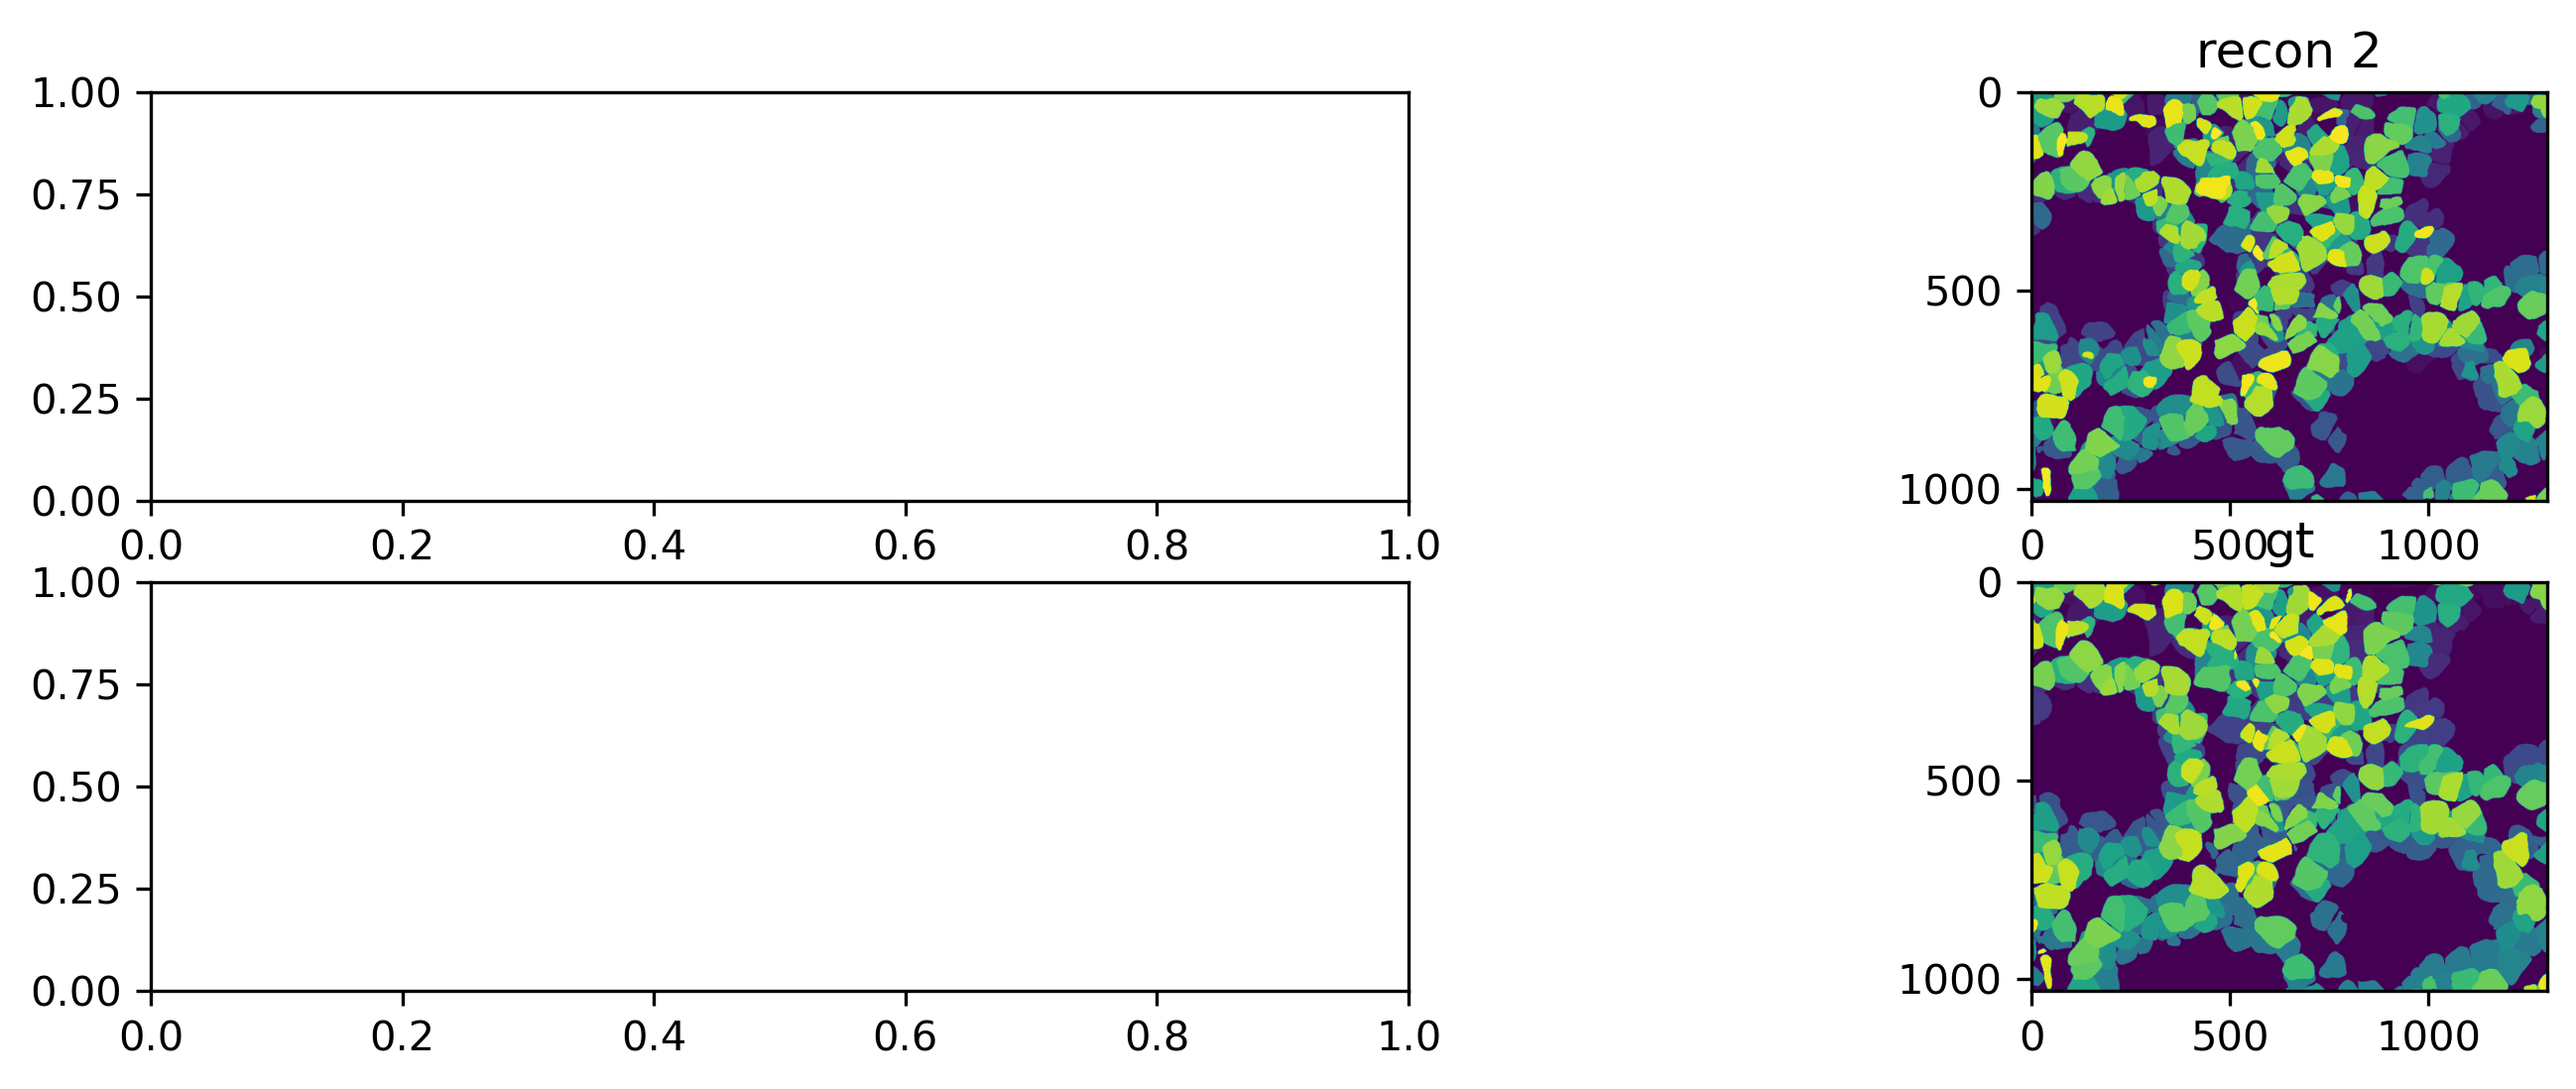

In [5]:
# use the logits computed by previous step, or load presaved flows in tiff format?
from cellpose.dynamics import compute_masks
if 0: #  use previous
    valid_flow = logits_out
else: # load pre saved tiffile 
    dsp = 1
    valid_flow_path = '/data/download_data/colon_dataset/colon_30/prediction_test_volume_swinunetr_monai_minsize100/logits*02*'
    valid_flow_file = glob.glob(valid_flow_path)
    valid_flow = tifffile.imread(valid_flow_file[0])

gt_flow_path = '/data/download_data/colon_dataset/colon_30/labels/*0002*'

print(glob.glob(gt_flow_path),'\n',valid_flow_file)
gt_file = tifffile.imread(glob.glob(gt_flow_path)[0])
from skimage import measure
gt_file =  measure.label(gt_file)


# if dsp >1:
#     flow = valid_flow[1:,::3,::3,::3]
# else:
#     flow = valid_flow
# #normalize
# # print(type(flow))
# flow = np.float32(flow)
# flow = (flow -127)/127
# print(flow.shape,logits_out[1:4,:,:,:].shape)
# # a = 10*logits_out[1:4,:,:,:]
# # print('model pred',np.max(a),np.min(a))
# print(np.max(flow),np.min(flow))
# print(type(logits_out[1:4,:,:,:]),type(flow))
# masks_recon1,p = compute_masks(5*valid_flow[1:4,:,:,:],valid_flow[0,:,:,:],niter=200,cellprob_threshold=0.5,flow_threshold=0.4, do_3D=True,min_size=50*50//(dsp*dsp), use_gpu=True)


masks_recon2,p = compute_masks(2*valid_flow[1:4,:,:,:],valid_flow[0,:,:,:],niter=200,cellprob_threshold=0.5,flow_threshold=0.4, do_3D=True,min_size=50*50//(dsp*dsp), use_gpu=True)

# masks_recon3,p = compute_masks(1*valid_flow[1:4,:,:,:],valid_flow[0,:,:,:],niter=200,cellprob_threshold=0.5,flow_threshold=0.4, do_3D=True,min_size=50*50//(dsp*dsp), use_gpu=True)


# masks_recon_gt,p = compute_masks(5*valid_flow[1:4,:,:,:],valid_flow[0,:,:,:],niter=200,cellprob_threshold=0.0,flow_threshold=50, do_3D=True,min_size=50*50//(dsp*dsp), use_gpu=True)

# print(masks_recon.shape)
# tifffile.imwrite(output_dir +'/cellpose_size50000_thre05_constant'+out_filename ,masks_recon)
# import matplotlib.pyplot as plt
fig,ax = plt.subplots(2,2,figsize=(12,4), dpi=300)
# #initialize matplotlib figure 1*2 subplots
# print(masks_recon1.shape)
# ax[0,0].imshow(np.max(masks_recon1,axis=0))
# ax[0,0].set_title('recon 1')
ax[0,1].imshow(np.max(masks_recon2,axis=0))
# ax[0,1].imshow(masks_recon2[16])

ax[0,1].set_title('recon 2')
# ax[1,1].imshow(masks_recon_gt[20])
ax[1,1].imshow(np.max(gt_file,axis=0))
ax[1,1].set_title('gt')

'/home/xzhang/Projects/cellpose'

In [14]:
from utils.utils import calculate_cell_volumes, plot_box_with_violin
import numpy as np
from scipy import ndimage

def size_filter(mask):
    # Get unique labels excluding the background label (0)
    labels = np.unique(mask)
    labels = labels[labels != 0]

    # Calculate the volume of each cell
    volumes = []
    for label in labels:
        cell_volume = np.sum(mask == label)
        if cell_volume < 40:
            mask[mask==label] = 0

    return mask



import numpy as np
from scipy.ndimage import label, find_objects,binary_closing

# def fill_small_holes_3d(mask, threshold):
#     # Label connected components (cells)
#     mask = mask.copy()
#     labeled_mask, num_features = label(mask)
    
#     # Find the unique labels
#     unique_labels = np.unique(labeled_mask)[1:]  # Exclude background label 0
    
#     # Iterate through each labeled region
#     for label_value in unique_labels:
#         # Extract the region for the current label
#         # region_slices = find_objects(labeled_mask == label_value)[0]
#         region_slices = (labeled_mask == label_value)
#         # break
#         region = mask[region_slices]
        
#         # Calculate the volume of the current region
#         volume = np.sum(region == label_value)
        
#         # If the volume is less than the threshold, fill the region with the label value
#         if volume < threshold:
#             mask[region_slices][region == 0] = label_value
#     return mask

def fill_small_holes_3d(mask, threshold):
    # Label connected components (cells)
    labeled_mask, num_features = label(mask)
    
    # Find the unique labels
    unique_labels = np.unique(labeled_mask)[1:]  # Exclude background label 0
    
    # Iterate through each labeled region
    for label_value in unique_labels:
        # Create a binary mask for the current region
        region_mask = labeled_mask == label_value
        
        # Calculate the volume of the current region
        volume = np.sum(region_mask)
        
        # If the volume is less than the threshold, fill the region with the label value
        if volume < threshold:
            mask[region_mask] = label_value
            
    return mask

from scipy.ndimage import find_objects, binary_fill_holes

def fill_small_holes_3d_v2(masks, min_size=1000,bin_closing_structure=np.ones((5,5,3)).astype(int)):

    masks = masks.copy()
    if masks.ndim > 3 or masks.ndim < 2:
        raise ValueError('masks_to_outlines takes 2D or 3D array, not %dD array'%masks.ndim)
    
    slices = find_objects(masks)
    j = 0
    for i,slc in enumerate(slices):
        if slc is not None:
            msk = masks[slc] == (i+1)
            npix = msk.sum()
            if min_size > 0 and npix < min_size:
                masks[slc][msk] = 0
            elif npix > 0:  
                # if bin_closing_structure is not None:
                #     for _ in range(3): # repeat 3 times
                #         msk = binary_closing(msk,bin_closing_structure)


                if msk.ndim==3:
                    for k in range(msk.shape[0]):
                        msk[k] = binary_closing(msk,bin_closing_structure)
                        msk[k] = binary_fill_holes(msk[k])
                        
                
                else:          
                    msk = binary_fill_holes(msk)
                masks[slc][msk] = (j+1)
                j+=1
    return masks
# Example usage:
# Assuming 'mask' is your 3D instance segmentation mask
# Set your desired volume threshold, e.g., threshold = 100
# filled_mask = fill_small_holes_3d(mask, threshold)


# Example usage:
# Assuming 'mask' is your 3D image mask as a numpy array
# cell_diameters = calculate_cell_diameters(mask)




# vol_seg1 = calculate_cell_volumes(masks_recon1)
# masks_recon2
# masks_recon2_post = fill_small_holes_3d(masks_recon2[:,:300,:300],100)
masks_recon2_post1 = fill_small_holes_3d_v2(masks_recon2,200,np.ones((25,25,5)))

# masks_recon2_post2 = fill_small_holes_3d_v2(masks_recon2,5000,np.ones((25,25,5)))


# vol_seg2 = calculate_cell_volumes(masks_recon2)

vol_seg2_post1 = calculate_cell_volumes(masks_recon2_post1)
# vol_seg2_post2 = calculate_cell_volumes(masks_recon2_post2)


# vol_gt = calculate_cell_volumes(gt_file)
# print(vol_seg1,vol_seg2)
# print(len(vol_seg1),len(vol_seg2),len(vol_seg3),len(vol_gt))
# print(np.median(vol_seg1),np.median(vol_seg2),np.median(vol_seg3),np.median(vol_gt))


In [25]:
print(masks_recon2.shape)

(129, 1030, 1300)


In [111]:
# print(len(vol_seg1),len(vol_seg2),len(vol_seg3),len(vol_gt))
# print(np.median(vol_seg1),np.median(vol_seg2),np.median(vol_seg3),np.median(vol_gt))

# print(np.mean(vol_seg1),np.mean(vol_seg2),np.mean(vol_seg3),np.mean(vol_gt))
# # print(len(vol_seg1),len(vol_seg2),len(vol_seg3))
# # print(np.median(vol_seg1),np.median(vol_seg2),np.median(vol_seg3))
# print(gt_file.shape,masks_recon1.shape)

497 507 530 536
51847.0 56993.0 49344.5 64906.0
60587.7323943662 60594.34319526627 56362.47735849056 68651.28171641791
(129, 1030, 1300) (129, 1030, 1300)


In [55]:
def fill_small_holes_3d_test(masks, min_size=1000,bin_closing_structure=np.ones((5,5,3)).astype(int)):
    print('test')
    masks = masks.copy()
    masks,num_features = label(masks)
    slices = find_objects(masks)
    j = 0
    for i,slc in enumerate(slices):
        if slc is not None:
            msk = masks[slc] == (i+1)
            npix = msk.sum()
            # if min_size > 0 and npix < min_size:
            #     print('delete')
            #     masks[slc][msk] = 0
            if npix > 0:  
                # if bin_closing_structure is not None:
                #     for _ in range(1): # repeat 3 times
                #         msk = binary_closing(msk,bin_closing_structure)
                if msk.ndim==3:
                    
                    for k in range(msk.shape[0]):
  
                        msk[k] = binary_closing(msk[k],bin_closing_structure)
                        msk[k] = binary_fill_holes(msk[k])
                
                else:          
                    msk = binary_fill_holes(msk)
                # masks[slc][msk] = (j+1)
                masks[slc][msk] = (j+1)
                j+=1
    return masks

def fill_small_holes_3d_test2(mask, threshold,bin_closing_structure=np.ones((5,5,3)).astype(int)):
    mask = mask.copy()
    # Label connected components (cells)
    labeled_mask, num_features = label(mask)
    
    # Find the unique labels
    unique_labels = np.unique(labeled_mask)[1:]  # Exclude background label 0
    
    # Iterate through each labeled region
    for label_value in unique_labels:
        # Create a binary mask for the current region
        msk = labeled_mask == label_value
        
        # Calculate the volume of the current region
        volume = np.sum(msk)
        
        if msk.ndim==3:
                
            for k in range(msk.shape[0]):

                msk[k] = binary_closing(msk[k],np.ones((10,10)))
                msk[k] = binary_fill_holes(msk[k])
            
        else:          
            msk = binary_fill_holes(msk)
        # masks[slc][msk] = (j+1)

        mask[msk] = label_value
            
    return mask


img_test = tifffile.imread('./vol_seg2_post2.tiff')
print(img_test.shape)
# img_test_post = fill_small_holes_3d_test(img_test,200,np.ones((30,30)))
img_test_post2 = fill_small_holes_3d_test2(img_test[:,385:800,650:1250],200,np.ones((10,10)))
# img_test_post2 = fill_small_holes_3d_test2(img_test,200,np.ones((10,10)))
# tifffile.imwrite('./vol_seg2_post1.tiff',np.uint8(img_test_post1))
# img_test_post = fill_small_holes_3d_test(img_test,200,np.ones((15,15)))
print(img_test.shape)
fig,ax = plt.subplots(2,2,figsize=(12,8), dpi=300)
# #initialize matplotlib figure 1*2 subplots
# print(masks_recon1.shape)
ax[0,0].imshow(img_test[96])
ax[0,0].set_title('recon 1')

ax[0,1].imshow(img_test_post[96])
ax[0,1].set_title('recon post')



# img2= img_test[96].copy()
# # print(img2.shape)
# img2_post = binary_closing(img2,np.ones((10,10)))

# ax[1,0].imshow(img_test_post2)
# ax[1,0].set_title('recon 2')

# ax[1,1].imshow(img2_post)
# ax[1,1].set_title('recon post')


for i in range(2):
       for j in range(2):
         ax[j,i].axis('off')
plt.tight_layout()

(129, 1030, 1300)


KeyboardInterrupt: 

In [54]:
tifffile.imwrite('./vol_seg2_post1_post_newalgo.tiff',np.uint8(img_test_post2))

507 502 536
57106.0 56648.0 64906.0
(129, 1030, 1300) (129, 1030, 1300)


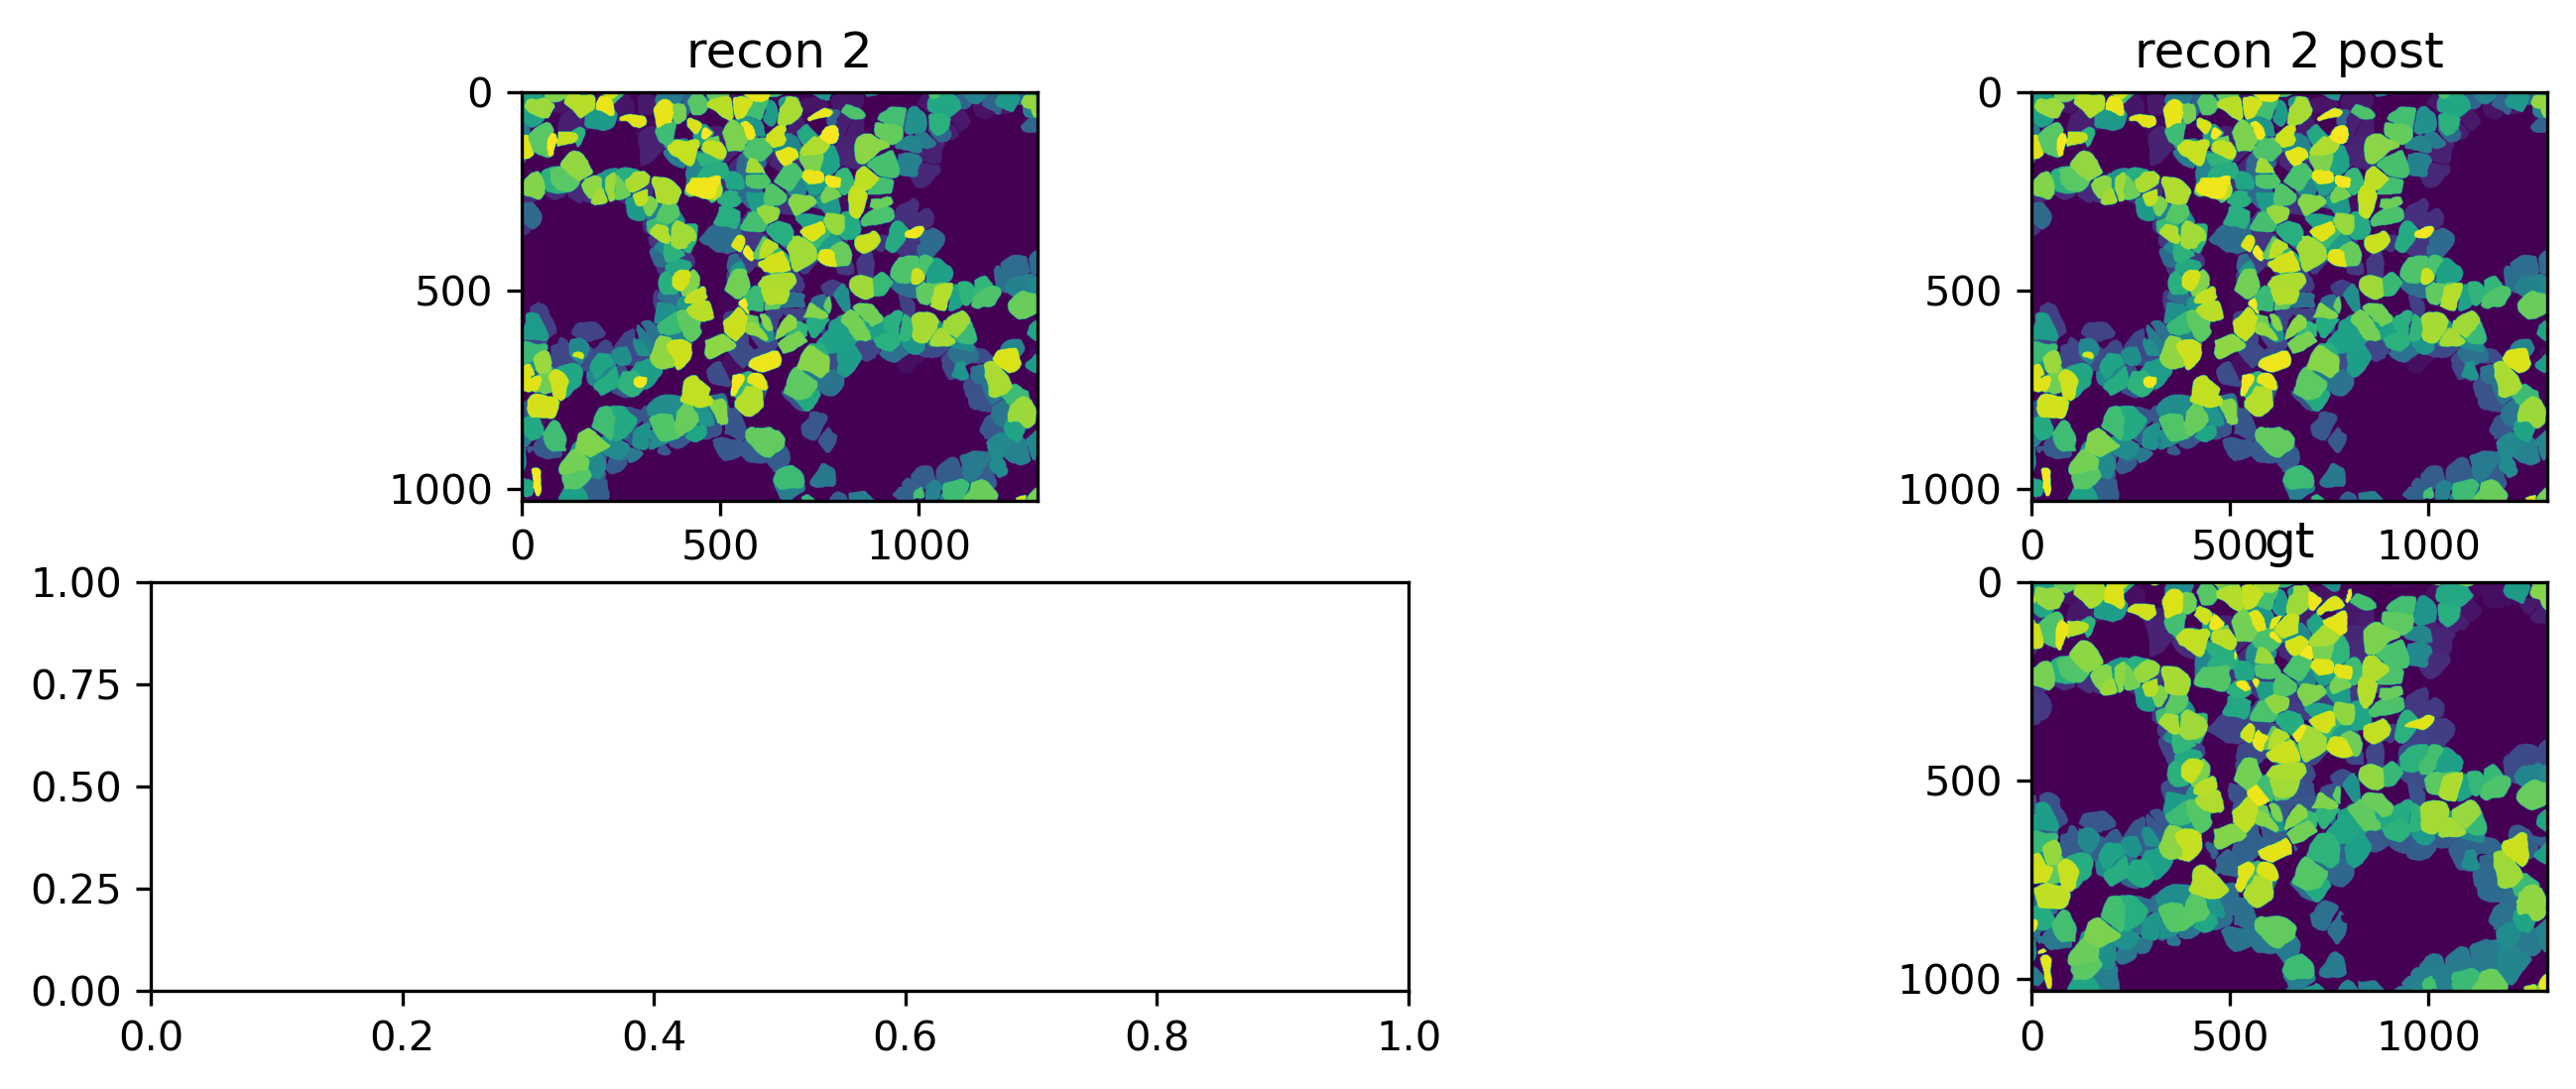

In [17]:

print(len(vol_seg2_post1),len(vol_seg2_post2),len(vol_gt))
print(np.median(vol_seg2_post1),np.median(vol_seg2_post2),np.median(vol_gt))


# print(len(vol_seg1),len(vol_seg2),len(vol_seg3))
# print(np.median(vol_seg1),np.median(vol_seg2),np.median(vol_seg3))
print(gt_file.shape,masks_recon2.shape)


fig,ax = plt.subplots(2,2,figsize=(12,4), dpi=300)
# #initialize matplotlib figure 1*2 subplots
# print(masks_recon1.shape)
ax[0,0].imshow(np.max(masks_recon2,axis=0))
ax[0,0].set_title('recon 2')
ax[0,1].imshow(np.max(masks_recon2_post1,axis=0))
ax[0,1].set_title('recon 2 post')
# ax[1,1].imshow(masks_recon_gt[20])
ax[1,1].imshow(np.max(gt_file,axis=0))
ax[1,1].set_title('gt')

tifffile.imwrite('./vol_seg2.tiff',np.uint16(masks_recon2))
tifffile.imwrite('./vol_seg2_post1.tiff',np.uint16(masks_recon2_post1))

Text(0, 0.5, 'False Positive')

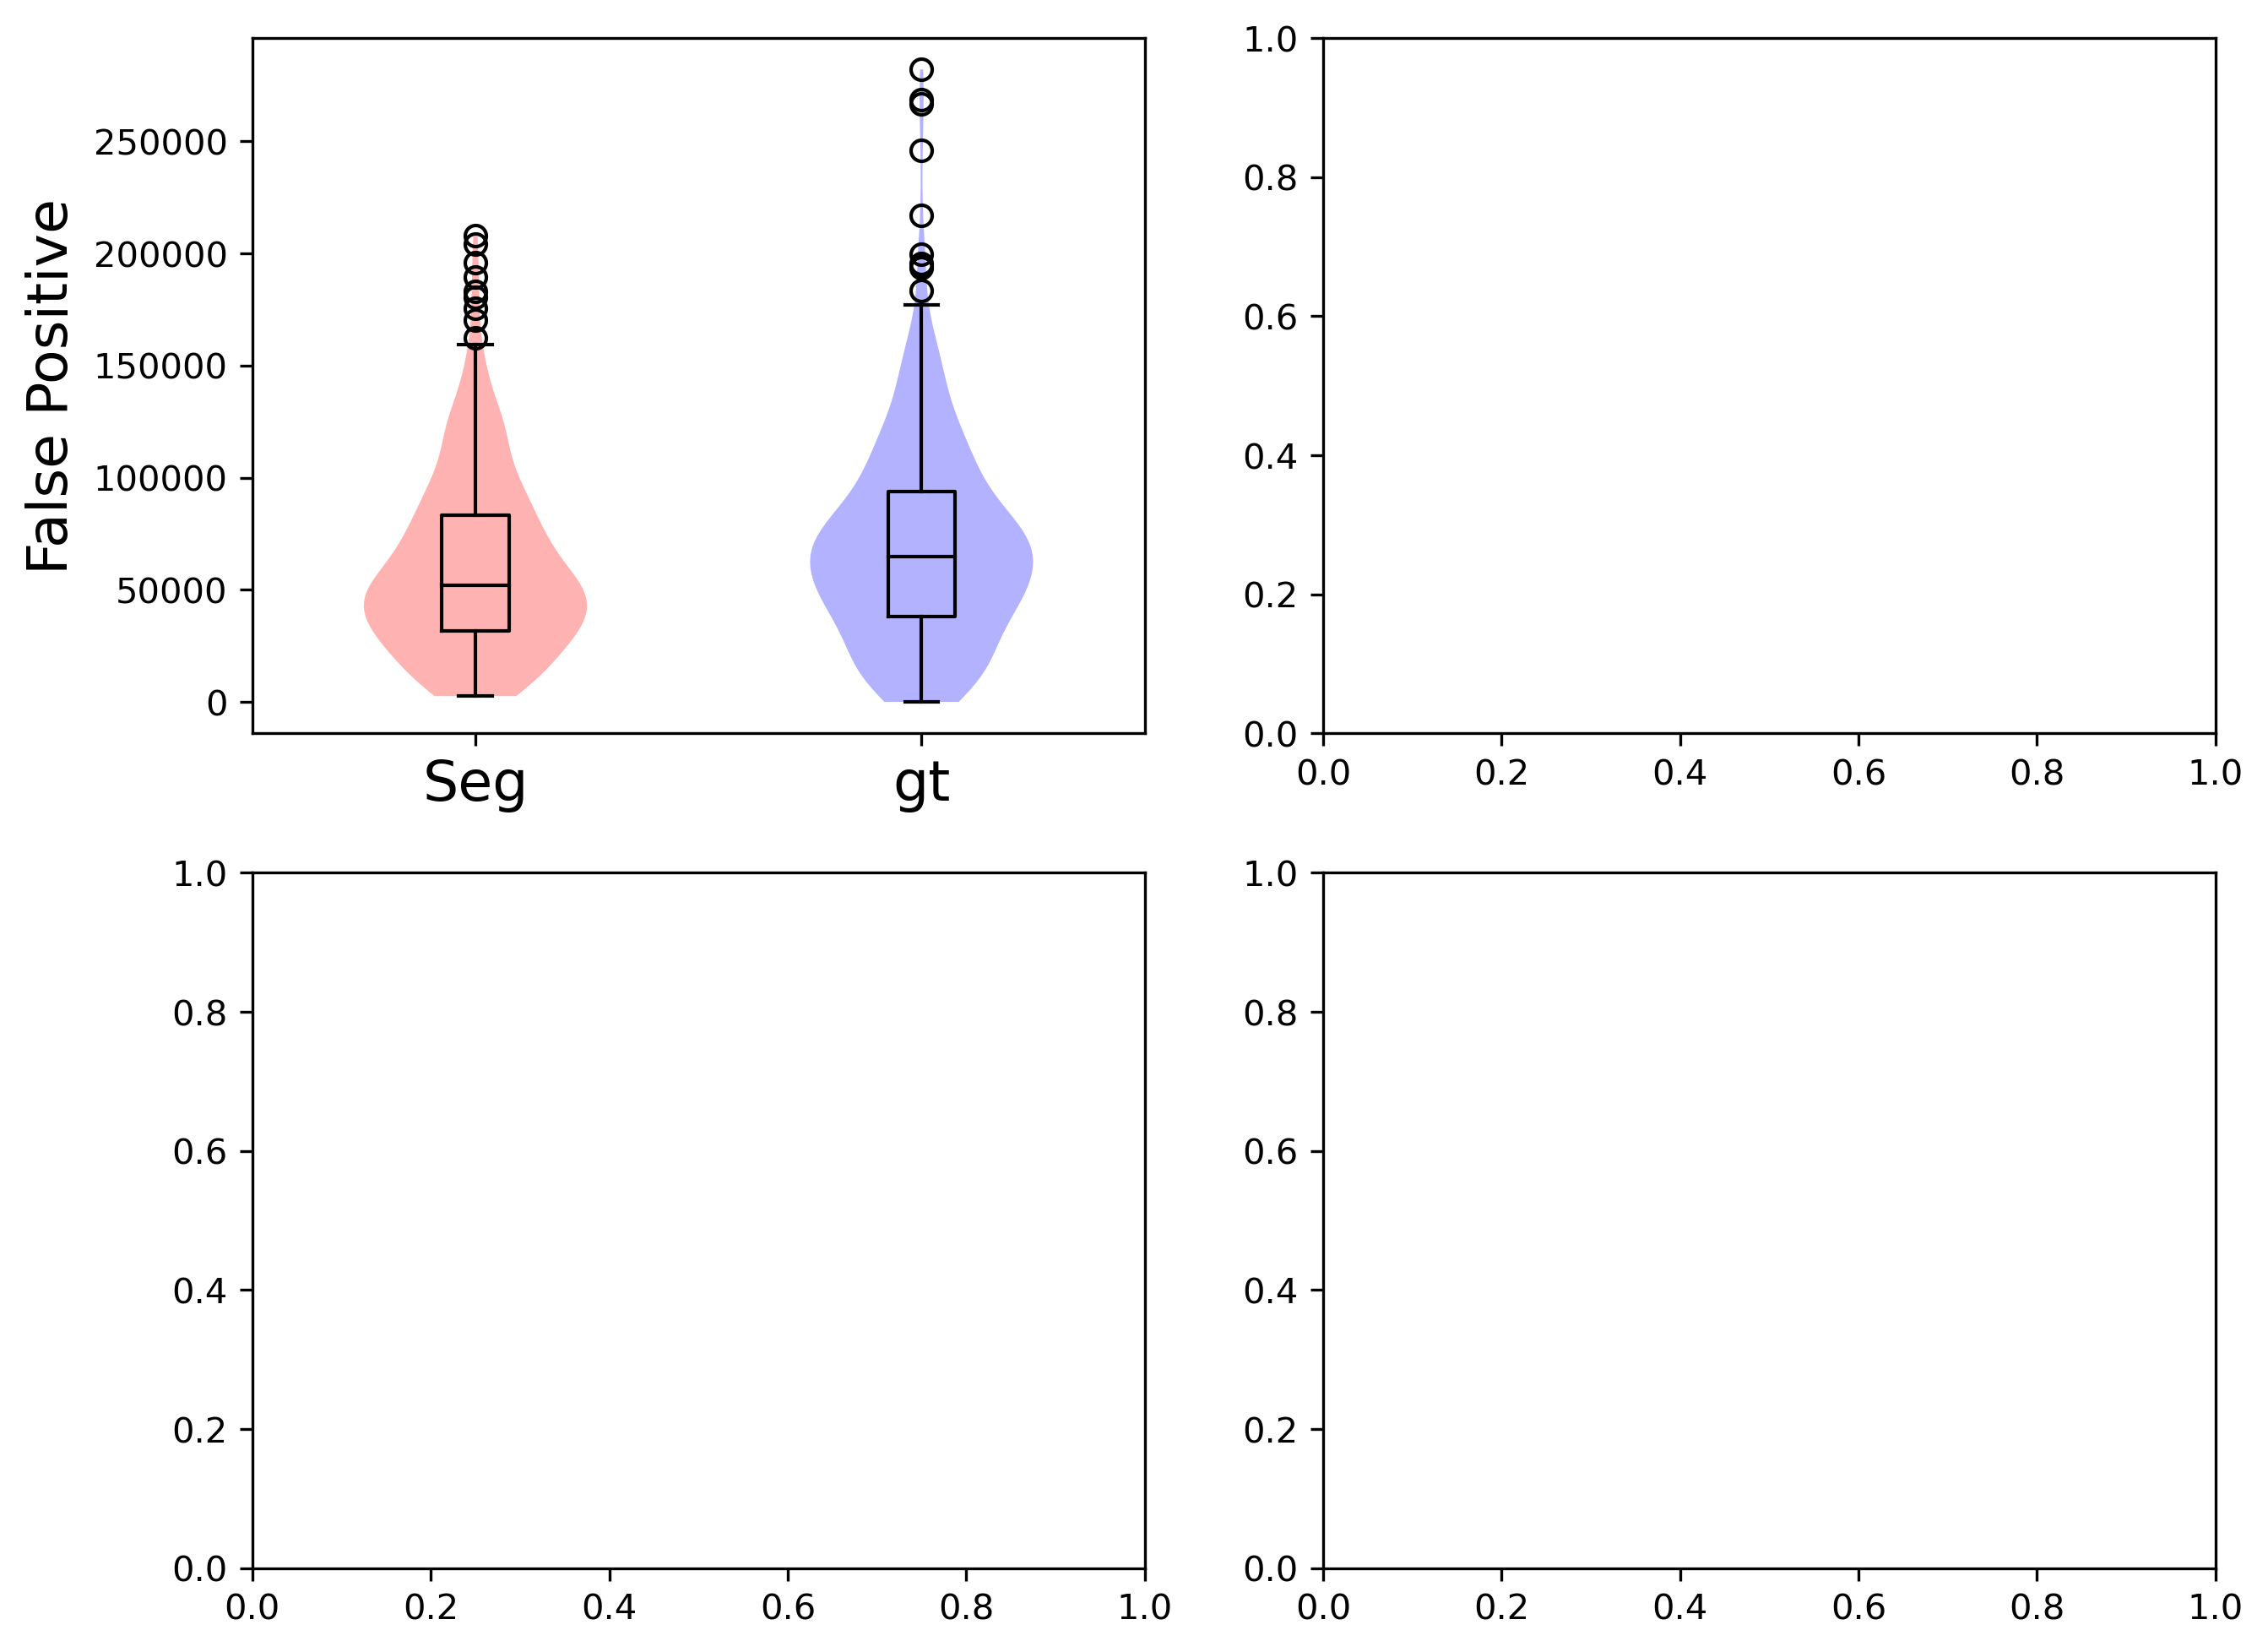

In [73]:
from utils.utils import plot_with_se, plot_box_with_violin
fig,ax = plt.subplots(2,2,figsize=(10,8), dpi=300)
ax[0,0] = plot_box_with_violin(ax[0,0],[vol_seg1,vol_gt],facecolorlist=['red','blue'])
ax[0,0].set_xticklabels(['Seg', 'gt'],fontsize =16)
ax[0,0].set_ylabel('False Positive',fontsize =16)

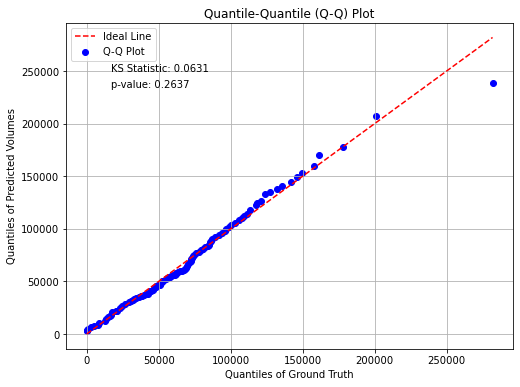

The two distributions are statistically the same (fail to reject null hypothesis).


In [77]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Sample data (replace with your actual data)
ground_truth = vol_gt
predicted_volumes = 1.15*np.array(vol_seg1)

# Sort both datasets in ascending order
ground_truth.sort()
predicted_volumes.sort()

# Calculate the quantiles for both datasets
quantiles_ground_truth = np.percentile(ground_truth, np.arange(0, 101, 1))
quantiles_predicted = np.percentile(predicted_volumes, np.arange(0, 101, 1))

# Create the Q-Q plot
plt.figure(figsize=(8, 6))
plt.scatter(quantiles_ground_truth, quantiles_predicted, c='blue', marker='o', label='Q-Q Plot')

# Perform KS test
ks_statistic, ks_p_value = stats.ks_2samp(ground_truth, predicted_volumes)

# Include KS test result in the plot
plt.text(0.1, 0.85, f'KS Statistic: {ks_statistic:.4f}', transform=plt.gca().transAxes)
plt.text(0.1, 0.80, f'p-value: {ks_p_value:.4f}', transform=plt.gca().transAxes)

plt.plot([0, max(quantiles_ground_truth)], [0, max(quantiles_ground_truth)], linestyle='--', color='red', label='Ideal Line')
plt.xlabel('Quantiles of Ground Truth')
plt.ylabel('Quantiles of Predicted Volumes')
plt.title('Quantile-Quantile (Q-Q) Plot')
plt.legend()
plt.grid(True)
plt.show()

# Perform hypothesis test based on p-value
alpha = 0.05  # Set your significance level
if ks_p_value > alpha:
    print("The two distributions are statistically the same (fail to reject null hypothesis).")
else:
    print("The two distributions are statistically different (reject null hypothesis).")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Sample data (replace with your actual data)
ground_truth = vol_gt
predicted_volumes = vol_seg
print('gt:',np.median(vol_gt),len(vol_gt))
print('pred:',np.median(vol_seg),len(vol_seg))
# Sort both datasets in ascending order
ground_truth.sort()
predicted_volumes.sort()

# Calculate the quantiles for both datasets
quantiles_ground_truth = np.percentile(ground_truth, np.arange(0, 101, 1))
quantiles_predicted = np.percentile(predicted_volumes, np.arange(0, 101, 1))

# Create the Q-Q plot
plt.figure(figsize=(8, 6))
plt.scatter(quantiles_ground_truth, quantiles_predicted, c='blue', marker='o', label='Q-Q Plot')

# Perform KS test
ks_statistic, ks_p_value = stats.ks_2samp(ground_truth, predicted_volumes)

# Include KS test result in the plot
plt.text(0.1, 0.85, f'KS Statistic: {ks_statistic:.4f}', transform=plt.gca().transAxes)
plt.text(0.1, 0.80, f'p-value: {ks_p_value:.4f}', transform=plt.gca().transAxes)

plt.plot([0, max(quantiles_ground_truth)], [0, max(quantiles_ground_truth)], linestyle='--', color='red', label='Ideal Line')
plt.xlabel('Quantiles of Ground Truth')
plt.ylabel('Quantiles of Predicted Volumes')
plt.title('Quantile-Quantile (Q-Q) Plot')
plt.legend()
plt.grid(True)
plt.show()

# Perform hypothesis test based on p-value
alpha = 0.05  # Set your significance level
if ks_p_value > alpha:
    print("The two distributions are statistically the same (fail to reject null hypothesis).")
else:
    print("The two distributions are statistically different (reject null hypothesis).")

# evaluate model prediction performance

In [14]:
from stardist_matching import matching
N_thresholds =5
raw_dir = '/home/xzhang/Projects/cellpose/Nanolive_mem_cellpose_data_v5_nor_augmented/images/*_0.tiff'
gt_dir = '/home/xzhang/Projects/cellpose/Nanolive_mem_cellpose_data_v5_nor_augmented/labels/*_0.tiff'
pred_dir='/home/xzhang/Projects/cellpose/Nanolive_mem_cellpose_data_v5_nor_augmented/results_3d_v5_swinunetr_monai_minsize_2500/*_0_pred.tiff'
# pred_dir='/home/xzhang/Projects/cellpose/Nanolive_mem_cellpose_data_v5_nor_augmented/results_3d_v5_swinunetr_monai_minsize_2500/*_0_pred.tiff'

raw_files = natsorted(glob.glob(raw_dir))
gt_files = natsorted(glob.glob(gt_dir))
pred_files = natsorted(glob.glob(pred_dir))

print(len(raw_files),len(gt_files),len(pred_files))
mAP_3d_list =np.zeros((len(pred_files),N_thresholds))

for i in range(len(pred_files)):
    for idxt,threshold in enumerate(np.linspace(0.5,1,N_thresholds)):
    # threshold = 0.5
        raw_img = tifffile.imread(raw_files[i])
        gt_img = tifffile.imread(gt_files[i])
        pred_img = tifffile.imread(pred_files[i])




        
        mAP_3d = matching(pred_img, gt_img, thresh=threshold).precision


        mAP_3d_list[i,idxt] = mAP_3d



        # mAP_2d_algo1_list.append(mAP_2d_algo1)
        # mAP_2d_algo2_list.append(mAP_2d_algo2)
        # mAP_3d_list.append(mAP_3d)
        # mAP_2d_algo1_after_training_list.append(mAP_2d_algo1_after_training)
        # mAP_2d_algo2_after_training_list.append(mAP_2d_algo2_after_training)
    
        # print(mAP_3d,mAP_2d_algo1,mAP_2d_algo2,mAP_2d_algo1_after_training,mAP_2d_algo2_after_training,'\n')


9 9 9


In [17]:
# print(mAP_3d_list.shape,mAP_2d_algo1_list.shape,mAP_2d_algo2_list.shape,mAP_2d_algo1_after_training_list.shape,mAP_2d_algo2_after_training_list.shape)
print(mAP_3d_list.shape)
print(mAP_3d_list)

(9, 5)
[[0.83333333 0.83333333 0.58333333 0.         0.        ]
 [0.84615385 0.61538462 0.46153846 0.11538462 0.        ]
 [1.         1.         0.95238095 0.57142857 0.        ]
 [0.94117647 0.94117647 0.94117647 0.52941176 0.        ]
 [0.92307692 0.92307692 0.92307692 0.76923077 0.        ]
 [0.77272727 0.72727273 0.40909091 0.09090909 0.        ]
 [0.46666667 0.31666667 0.16666667 0.         0.        ]
 [0.94736842 0.89473684 0.78947368 0.26315789 0.        ]
 [0.72340426 0.65957447 0.34042553 0.         0.        ]]


Text(0, 0.5, 'mAP')

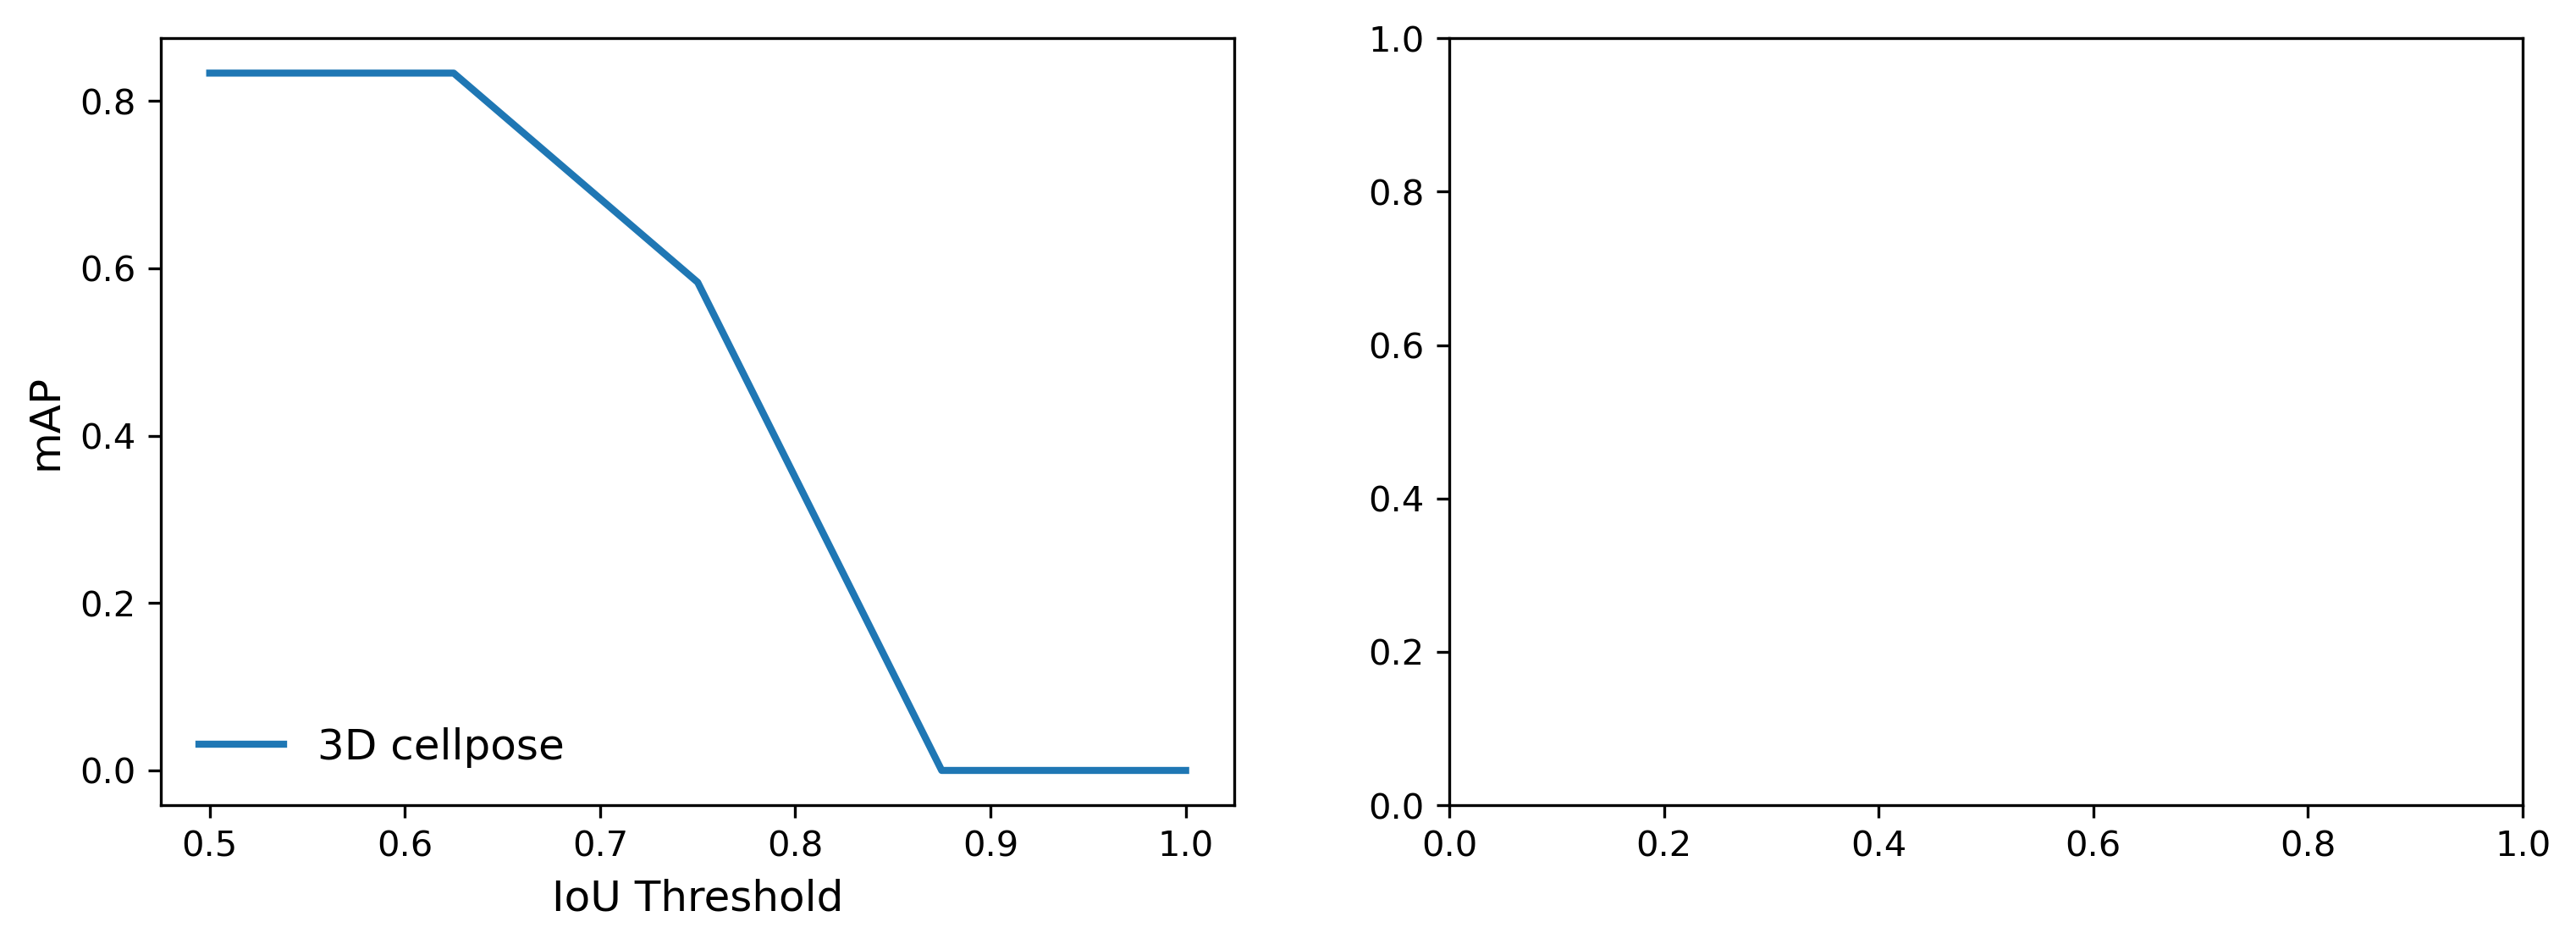

In [15]:
from matplotlib import pyplot as plt
fig,ax = plt.subplots(1,2,figsize=(12,4), dpi=300)
idx =0
ax[0].plot(np.linspace(0.5,1,N_thresholds),mAP_3d_list[idx],linewidth=2,label='3D cellpose') 
# ax[0].plot(np.linspace(0.5,1,N_thresholds),mAP_2d_algo1_list[idx],linewidth=2,label='2D cellpose,v1') 
# ax[0].plot(np.linspace(0.5,1,N_thresholds),mAP_2d_algo1_after_training_list[idx],linewidth=2,label='2D cellpose,v1, finetuned') 
# ax[0].plot(np.linspace(0.5,1,N_thresholds),mAP_2d_algo2_list[idx],linewidth=2,label='2D cellpose,v2') 
# ax[0].plot(np.linspace(0.5,1,N_thresholds),mAP_2d_algo2_after_training_list[idx],linewidth=2,label='2D cellpose,v2, finetuned') 
# show legend with boxoff with fontsize 12
ax[0].legend(loc='lower left',frameon=False,fontsize=12)
# ax[0].legend()
# change font size in the figure
ax[0].set_xlabel('IoU Threshold',fontsize=12)
ax[0].set_ylabel('mAP',fontsize=12)

(70, 624, 924)


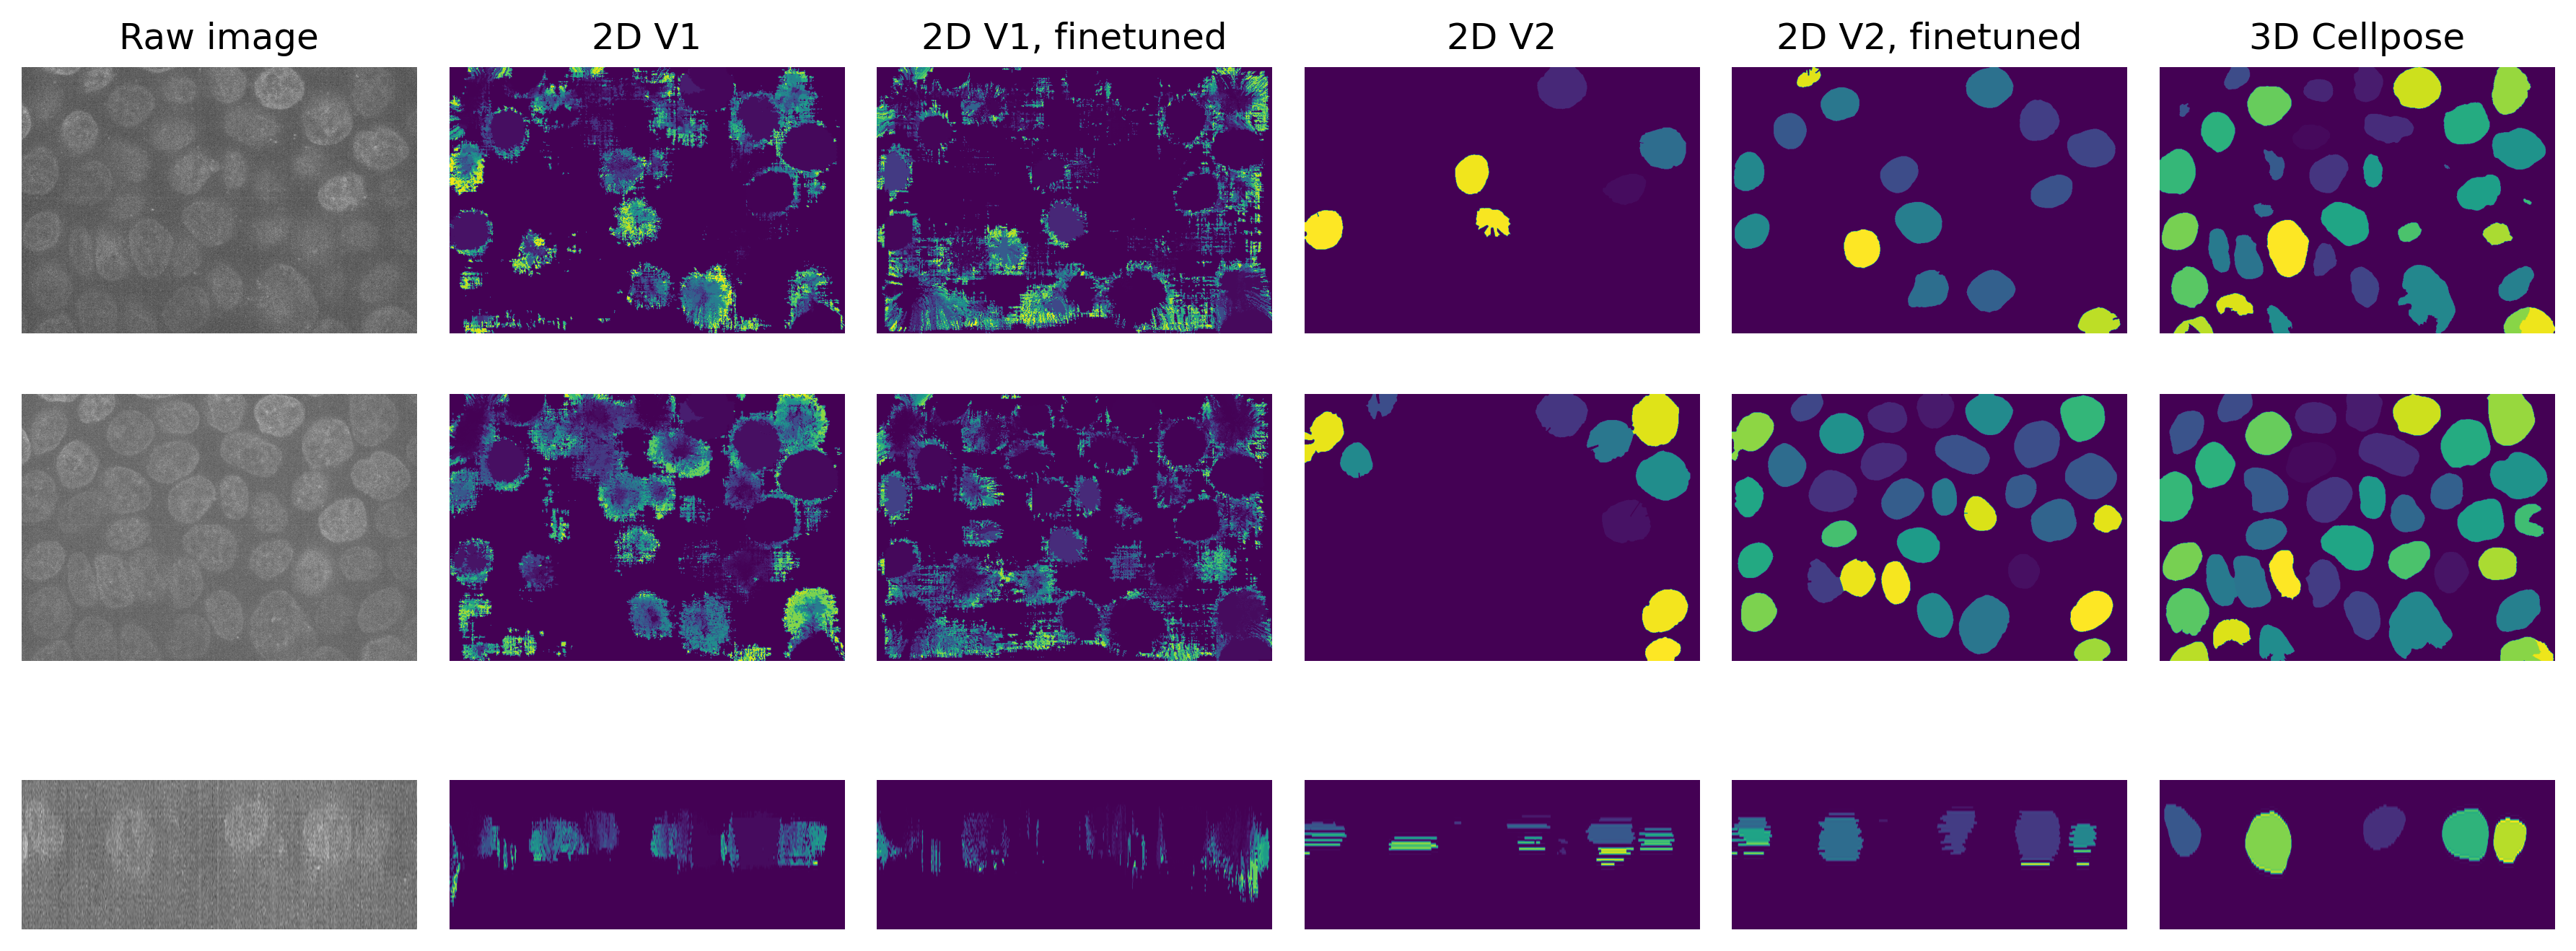

In [31]:
# import tifffile
# from matplotlib import pyplot as plt
# import scipy.ndimage as ndimage
# file_idx = 1
# slice1 = 35
# slice2 = 28
# side_slice1 = 100
# img_raw = tifffile.imread(raw_image_files[file_idx])
# img_2d_algo1 = tifffile.imread(results_2d_files_algo1[file_idx])
# img_2d_algo2 = tifffile.imread(results_2d_files_algo2[file_idx])  
# img_2d_algo1_after_training = tifffile.imread(results_2d_files_algo1_after_training[file_idx])
# img_2d_algo2_after_training = tifffile.imread(results_2d_files_algo2_after_training[file_idx]) 
# img_3d = tifffile.imread(results_3d_files[file_idx]) 
# print(img_3d.shape)

# fig,ax = plt.subplots(3,6,figsize=(12,5), dpi=300)

# ax[0,0].imshow(img_raw[slice1],cmap='gray')
# ax[0,0].set_title('Raw image')
# ax[0,1].imshow(img_2d_algo1[slice1])
# ax[0,1].set_title('2D V1')
# ax[0,2].imshow(img_2d_algo1_after_training[slice1])
# ax[0,2].set_title('2D V1, finetuned')

# ax[0,3].imshow(img_2d_algo2[slice1])
# ax[0,3].set_title('2D V2')
# ax[0,4].imshow(img_2d_algo2_after_training[slice1])
# ax[0,4].set_title('2D V2, finetuned')
# ax[0,5].imshow(img_3d[slice1])
# ax[0,5].set_title('3D Cellpose')



# ax[1,0].imshow(img_raw[slice2],cmap='gray')
# ax[1,1].imshow(img_2d_algo1[slice2])
# ax[1,2].imshow(img_2d_algo1_after_training[slice2])

# ax[1,3].imshow(img_2d_algo2[slice2])
# ax[1,4].imshow(img_2d_algo2_after_training[slice2])
# ax[1,5].imshow(img_3d[slice2])

# # 
# ax[2,0].imshow(ndimage.zoom(img_raw[:,side_slice1],(5,1)),cmap='gray')
# ax[2,1].imshow(ndimage.zoom(img_2d_algo1[:,side_slice1],(5,1)))
# ax[2,2].imshow(ndimage.zoom(img_2d_algo1_after_training[:,side_slice1],(5,1)))

# ax[2,3].imshow(ndimage.zoom(img_2d_algo2[:,side_slice1],(5,1)))
# ax[2,4].imshow(ndimage.zoom(img_2d_algo2_after_training[:,side_slice1],(5,1)))
# ax[2,5].imshow(ndimage.zoom(img_3d[:,side_slice1],(5,1)))

# for i in range(6):
#        for j in range(3):
#          ax[j,i].axis('off')
# plt.tight_layout()


## Cleanup data directory

Remove directory if a temporary was used.

In [73]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()